In [1]:
import datashader as ds
import datashader.transfer_functions as tf
import datashader.glyphs
from datashader import reductions
from datashader.core import bypixel
from datashader.utils import lnglat_to_meters as webm, export_image
from datashader.colors import colormap_select, Greys9, viridis, inferno
import copy


from pyproj import Proj, transform
import numpy as np
import pandas as pd
import urllib
import json
import datetime
import colorlover as cl

import plotly.offline as py
import plotly.graph_objs as go
from plotly import tools

from shapely.geometry import Point, Polygon, shape
# In order to get shapley, you'll need to run [pip install shapely.geometry] from your terminal

from functools import partial

from IPython.display import GeoJSON

py.init_notebook_mode()

In [3]:
ny = pd.read_csv('/Users/xiaomengkong/Desktop/SPS/DATA608/HW/hw2/nyc_pluto_18v2_csv/pluto_18v2.csv')
ny = ny[(ny['yearbuilt'] > 1850) & (ny['yearbuilt'] < 2020) & (ny['numfloors'] != 0)]

In [4]:
wgs84 = Proj("+proj=longlat +ellps=GRS80 +datum=NAD83 +no_defs")
nyli = Proj("+proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 +x_0=300000 +y_0=0 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs")
ny['xcoord'] = 0.3048*ny['xcoord']
ny['ycoord'] = 0.3048*ny['ycoord']
ny['lon'], ny['lat'] = transform(nyli, wgs84, ny['xcoord'].values, ny['ycoord'].values)

ny = ny[(ny['lon'] < -60) & (ny['lon'] > -100) & (ny['lat'] < 60) & (ny['lat'] > 20)]

#Defining some helper functions for DataShader
background = "black"
export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

In [5]:
trace = go.Scatter(
    # I'm choosing BBL here because I know it's a unique key.
    x = ny.groupby('yearbuilt').count()['bbl'].index,
    y = ny.groupby('yearbuilt').count()['bbl']
)

layout = go.Layout(
    xaxis = dict(title = 'Year Built'),
    yaxis = dict(title = 'Number of Lots Built')
)

fig = go.Figure(data = [trace], layout = layout)

py.iplot(fig)

In [20]:
ny['YearBuiltDatetime'] = pd.to_datetime(ny['yearbuilt'], format = '%Y')
ny_groupByYear = ny.groupby('YearBuiltDatetime').count()['bbl']



trace = go.Scatter(
    x = ny_groupByYear.resample('5A').sum().index,
    y = ny_groupByYear.resample('5A').sum()
)

layout = go.Layout(
    xaxis = dict(title = 'Year Built'),
    yaxis = dict(title = 'Number of Lots Built')
)

fig = go.Figure(data = [trace], layout = layout)

py.iplot(fig, filename = 'ny-year-built-5bin')

In [116]:
ny['stories'] = 10*np.floor(ny['numfloors']/10).apply(int)
ny['stories'] = ny['stories'].apply(lambda x: x if x <= 110 else 210)
ny_storiesAndYear = ny.groupby(['stories', 'YearBuiltDatetime'])['bbl'].count()

In [117]:
trace = go.Scatter(
    x = ny_groupByYear.cumsum().index,
    y = 100*ny_groupByYear.cumsum()/ ny_groupByYear.sum()
)

layout = go.Layout(
    xaxis = dict(title = 'Year Built', range = [datetime.datetime(1930,1,1), datetime.datetime(2017,1,1)]),
    yaxis = dict(title = 'Cumulative Percentage Built', ticksuffix = '%')
)

fig = go.Figure(data = [trace], layout = layout)

py.iplot(fig, filename = 'cumsum-ny')

In [119]:
traces = []
for group in ny_storiesAndYear.index.levels[0]:
    traces.append(
        go.Scatter(
            name = str(group) + ' Stories',
            x = ny_storiesAndYear[group].index,
            y = ny_storiesAndYear[group].cumsum()
        )
    )

layout = go.Layout(
    xaxis = dict(title = 'Year Built'),
    yaxis = dict(title = 'Cumulative Percentage Built')
)

fig = tools.make_subplots(rows=13, cols=1, shared_xaxes=True)

for row,trace in enumerate(traces):
    fig.append_trace(trace, row+1, 1)

fig['layout'].update(height = 900)
for axis in ['yaxis1', 'yaxis2', 'yaxis3', 'yaxis4', 'yaxis5','yaxis6','yaxis7','yaxis8','yaxis9','yaxis10','yaxis11','yaxis12','yaxis13']:
    fig['layout'][axis].update(ticksuffix = '')
fig['layout']['xaxis1'].update(range = [datetime.datetime(1899,1,1), datetime.datetime(2017,1,1)])

py.iplot(fig, filename = 'cumsum-ny-grouped')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  
[ (2,1) x1,y2 ]  
[ (3,1) x1,y3 ]  
[ (4,1) x1,y4 ]  
[ (5,1) x1,y5 ]  
[ (6,1) x1,y6 ]  
[ (7,1) x1,y7 ]  
[ (8,1) x1,y8 ]  
[ (9,1) x1,y9 ]  
[ (10,1) x1,y10 ]
[ (11,1) x1,y11 ]
[ (12,1) x1,y12 ]
[ (13,1) x1,y13 ]



In [120]:
yearbins = 200
floorbins = 200

yearBuiltCut = pd.cut(ny['yearbuilt'], np.linspace(ny['yearbuilt'].min(), ny['yearbuilt'].max(), yearbins))
numFloorsCut = pd.cut(ny['numfloors'], np.logspace(1, np.log(ny['numfloors'].max()), floorbins))

xlabels = np.floor(np.linspace(ny['yearbuilt'].min(), ny['yearbuilt'].max(), yearbins))
ylabels = np.floor(np.logspace(1, np.log(ny['numfloors'].max()), floorbins))

data = [
    go.Heatmap(z = ny.groupby([numFloorsCut, yearBuiltCut])['bbl'].count().unstack().fillna(0).values,
              colorscale = 'Greens', x = xlabels, y = ylabels)
]

py.iplot(data)

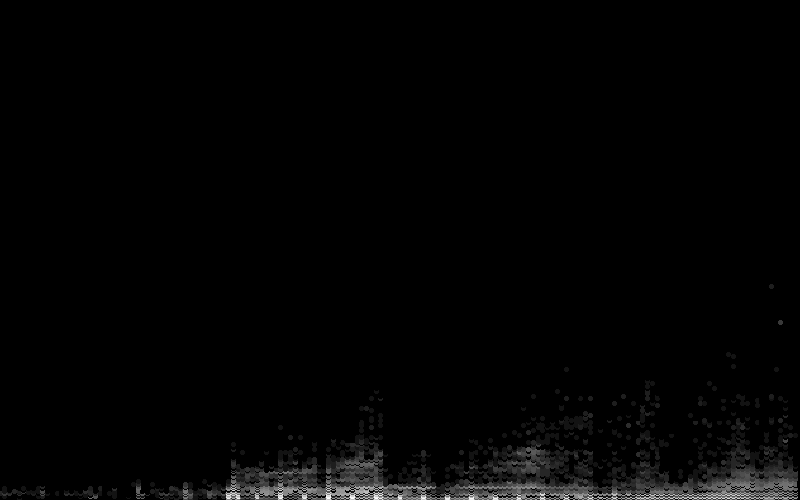

In [121]:
cvs = ds.Canvas(800, 500, x_range = (ny['yearbuilt'].min(), ny['yearbuilt'].max()), 
                                y_range = (ny['numfloors'].min(), ny['numfloors'].max()))
agg = cvs.points(ny, 'yearbuilt', 'numfloors')
view = tf.shade(agg, cmap = cm(Greys9), how='log')
export(tf.spread(view, px=2), 'yearvsnumfloors')


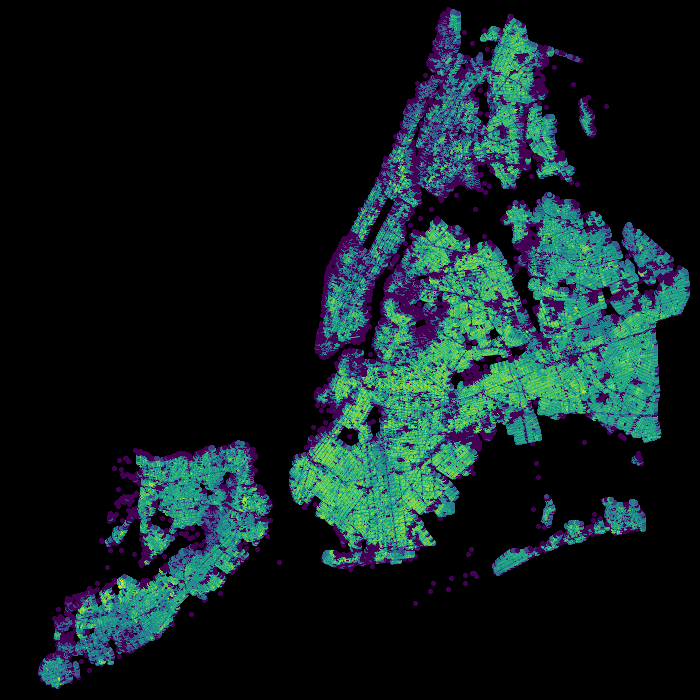

In [144]:
NewYorkCity   = (( -74.29,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'lon', 'lat')
view = tf.shade(agg, cmap = cm(viridis), how='log')
export(tf.spread(view, px=2), 'firefly')


In [161]:
ny['assessstruct'] = ny['assesstot'] - ny['assessland']

al25 = np.percentile(ny['assessland'].values, 25)
al75 = np.percentile(ny['assessland'].values, 75)
as25 = np.percentile(ny['assessstruct'].values, 25)
as75 = np.percentile(ny['assessstruct'].values, 75)

ny['assessland3tile'] = ny['assessland'].apply(lambda x: 1 if x < al25 else 2 if x < al75 else 3)
ny['assessstruct3tile'] = ny['assessstruct'].apply(lambda x: 1 if x < as25 else 2 if x < as75 else 3)

ny['assessall3tile'] = ny['assessland3tile'].apply(str) + ny['assessstruct3tile'].apply(str) + 'c'

ny['assessall3tile'] = pd.Categorical(ny['assessall3tile'])
    
color_key = {
    '11c': '#e8e8e8',
    '12c': '#8cb789',
    '13c': '#72c16c',
    '21c': '#ce9898',
    '22c': '#727227',
    '23c': '#bff900',
    '31c': '#ba6666',
    '32c': '#cc7d24',
    '33c': '#f2f20e'
}


SyntaxError: invalid syntax (<ipython-input-161-5bb1051f38cf>, line 27)

/Users/xiaomengkong/anaconda3/lib/python3.7/site-packages/datashader/utils.py:348: FutureWarning:

`Series.cat.categorical` has been deprecated. Use the attributes on 'Series.cat' directly instead.



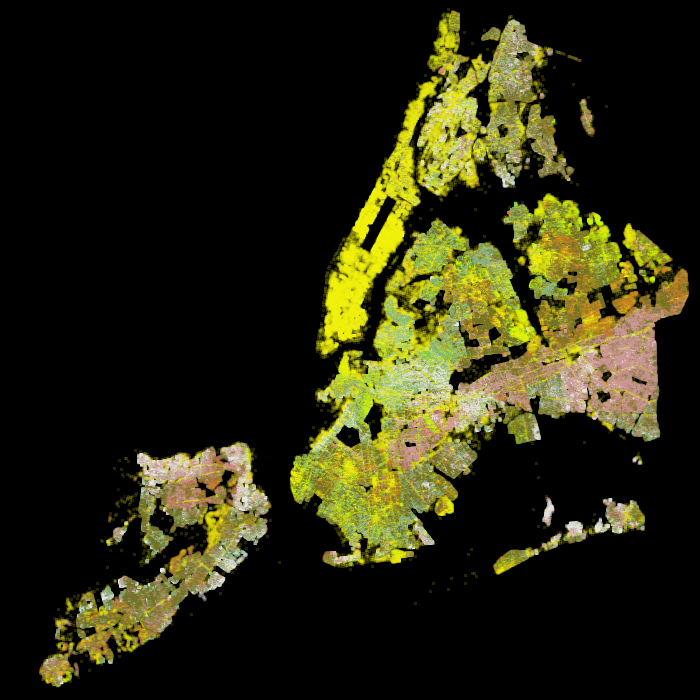

In [160]:
NewYorkCity   = (( -74.29,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'lon', 'lat', ds.count_cat('assessall3tile'))
view = tf.shade(agg, color_key = color_key)
export(tf.spread(view, px=1), 'bivariate')

For the second problem, I mimic the answer that provide in github. I changed the colors accordingly to adjust graph to find which area is overbuilt and which is underbuilt. 

Firstly, I change the percentile rank to 1st quartile and 3rd quartile as my standard. I defined that if tax assessment is lower than 25%, it will be considered as low usage, denoted by "1", for both cases. "2" for medium usages, and 3 for high usages. so 11, I used the lightest grey to represent, 33 which is the combination of highest usages, so I used the brightest yellow to represent.

Yellower (brighter) or greener represent the higher tax assessments of structer, redder represents the higher tax assessments of lands. Apparently, from the graph, we can tell that, Manhattan is the brightest yellow which means it is overbuilt, also for some parts of Brooklyn, Bronx, Queen that are closer to Manhattan area are bright yellow. When the map moves toward East, Long Island, Tax Assessment shifts to land Assessment Since the density of population becomes smaller and smaller. The darker green is properly correlated with their land value. 